**importing Librires**

In [1]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.12.0


**Exploring Dataset**

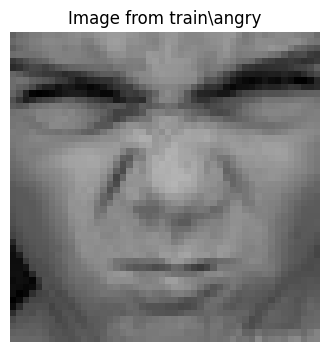

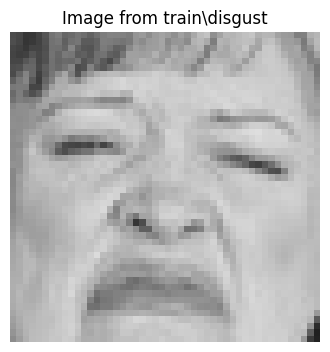

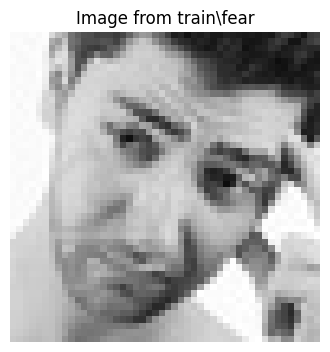

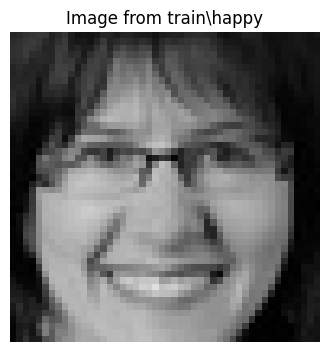

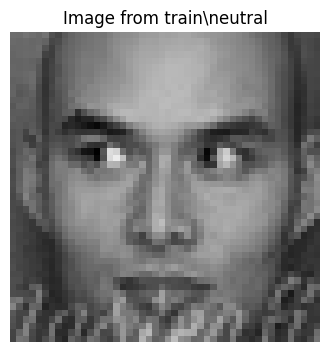

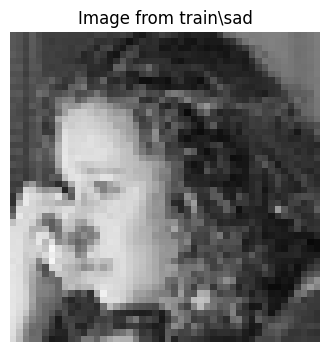

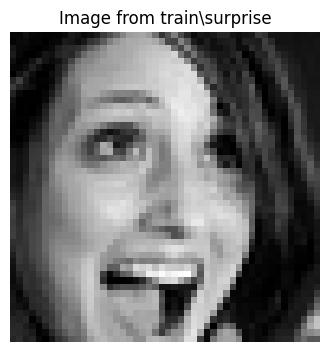

In [2]:
# Path to the main train directory
train_dir = 'train'

# Get all subdirectories within the train directory
subdirectories = [os.path.join(train_dir, d) for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Loop through each subdirectory
for subdir in subdirectories:
    # Get all image files in the current subdirectory
    images = [os.path.join(subdir, f) for f in os.listdir(subdir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
    
    if not images:
        print(f"No images found in {subdir}")
        continue  # Skip this subdirectory if no images are found
    
    # Choose a random image from the current subdirectory
    image_path = random.choice(images)
    image = cv2.imread(image_path)  # Read the image
    
    # Check if the image was loaded successfully
    if image is None:
        print(f"Failed to load image: {image_path}")
        continue  # Skip to the next subdirectory
    
    plt.figure(figsize=(4, 5))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert from BGR to RGB 
    plt.title(f"Image from {subdir}")
    plt.axis('off')

plt.show()  # Display the plot after all images are processed

**Preparing Data for Training**

In [3]:
# Parameters
img_size = 48
batch_size = 64
epochs = 50

In [4]:
datagen_train = ImageDataGenerator()

train_generator = datagen_train.flow_from_directory(
    "train",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

Found 28709 images belonging to 7 classes.


In [5]:
datagen_validation = ImageDataGenerator()

validation_generator = datagen_validation.flow_from_directory(
    "test",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

Found 7178 images belonging to 7 classes.


**Defining Model**

In [6]:
# Function for adding a convolutional block
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    return x

In [7]:
# Function for adding a dense block
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    return x

In [8]:
# Function for building the complete model
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 32, (3, 3))
    conv_2 = Convolution(conv_1, 64, (5, 5))
    conv_3 = Convolution(conv_2, 128, (3, 3))
    conv_4 = Convolution(conv_3, 256, (3, 3))

    flatten = Flatten()(conv_4)
    
    dense_1 = Dense_f(flatten, 512)
    dense_2 = Dense_f(dense_1, 256)

    output = Dense(7, activation="softmax")(dense_2)
    model = Model(inputs=[inputs], outputs=[output])
    
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

    return model

In [9]:
# Creating the model
model = model_fer((48, 48, 1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0     

In [10]:
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

In [11]:
checkpoint = ModelCheckpoint("model_weights.weights.h5", monitor  ='val_accuracy', save_weights_only = True, mode = 'max', verbose =1)
callbacks = [checkpoint]

**Training the model**

In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

Epoch 1/50
448/448 [==============================] - ETA: 0s - loss: 1.7642 - accuracy: 0.3137
Epoch 1: saving model to model_weights.weights.h5
448/448 [==============================] - 275s 611ms/step - loss: 1.7642 - accuracy: 0.3137 - val_loss: 1.7389 - val_accuracy: 0.3605
Epoch 2/50
448/448 [==============================] - ETA: 0s - loss: 1.4481 - accuracy: 0.4450
Epoch 2: saving model to model_weights.weights.h5
448/448 [==============================] - 97s 217ms/step - loss: 1.4481 - accuracy: 0.4450 - val_loss: 1.3113 - val_accuracy: 0.4994
Epoch 3/50
448/448 [==============================] - ETA: 0s - loss: 1.3141 - accuracy: 0.4968
Epoch 3: saving model to model_weights.weights.h5
448/448 [==============================] - 105s 234ms/step - loss: 1.3141 - accuracy: 0.4968 - val_loss: 1.3687 - val_accuracy: 0.4622
Epoch 4/50
448/448 [==============================] - ETA: 0s - loss: 1.2419 - accuracy: 0.5257
Epoch 4: saving model to model_weights.weights.h5
448/448 [===

**Model Evaluation**

In [13]:
model.evaluate(validation_generator)

113/113 [==============================] - 5s 43ms/step - loss: 1.3569 - accuracy: 0.6152


[1.356886386871338, 0.61521315574646]

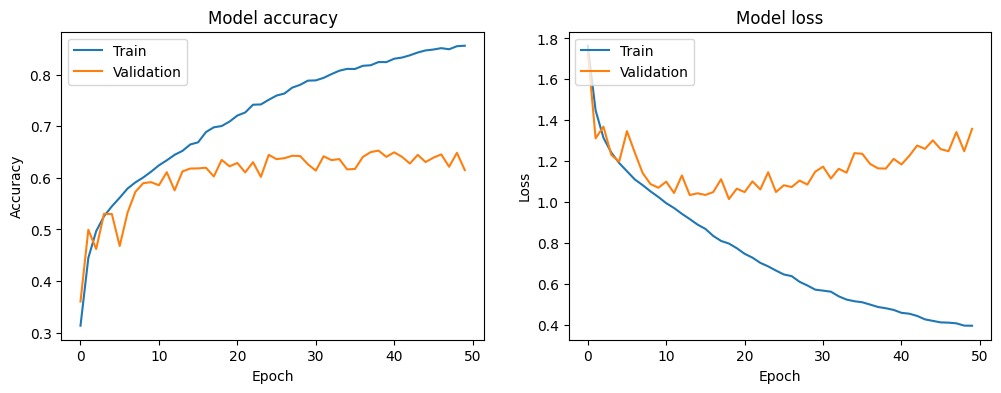

In [14]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

**Saving Model**

In [16]:
model_json = model.to_json()
with open("model_a2.json","w") as json_file:
    json_file.write(model_json)